In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
#documents loading
corpus = ["earth jupyter planet", "jupyter earth planet", "planet earth jupyter",
          "orange strawberry fruit", "strawberry orange fruit", "fruit orange strawberry"]

In [3]:
# tokenization
tokenized_corpus = [sent.split(" ") for sent in corpus]
print(tokenized_corpus)

[['earth', 'jupyter', 'planet'], ['jupyter', 'earth', 'planet'], ['planet', 'earth', 'jupyter'], ['orange', 'strawberry', 'fruit'], ['strawberry', 'orange', 'fruit'], ['fruit', 'orange', 'strawberry']]


In [4]:
# numeralization
flatten = lambda l: [item for sublist in l for item in sublist]
flatten(tokenized_corpus)
unique_words = list(set(flatten(tokenized_corpus)))
print(unique_words)

['orange', 'strawberry', 'jupyter', 'earth', 'planet', 'fruit']


In [5]:
#mapping between words and index
word2index= {v:idx for idx, v in enumerate(unique_words)}
word2index['jupyter']

2

In [6]:
unique_words.append('<UNK>')
word2index['<UNK>'] = 6

In [7]:
#mapping index to words
index2word = {v:k for k,v in word2index.items()}
index2word

{0: 'orange',
 1: 'strawberry',
 2: 'jupyter',
 3: 'earth',
 4: 'planet',
 5: 'fruit',
 6: '<UNK>'}

In [8]:
#preparing data 
import numpy as np

def random_batch(batch_size, corpus):
    skipgrams = []
    
    #loop each corpus
    for doc in tokenized_corpus:
        #loop each document
        for i in range(1, len(doc)-1):
            #center word
            center = word2index[doc[i]]
            #outside words 2
            outside_words = (word2index[doc[i-1]], word2index[doc[i+1]])
            #we append each of the outside words to a list
            for each_out in outside_words:
                skipgrams.append([center, each_out])
                #center1->outside1; center2->outside2
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    inputs, labels = [],[]
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])

    return np.array(inputs), np.array(labels)
x,y = random_batch(2,tokenized_corpus)

In [9]:
embedding = nn.Embedding(7,2)

In [10]:
x_tensor = torch.LongTensor(x)
embedding(x_tensor).shape #(batch_size,1,emb_size)

torch.Size([2, 1, 2])

In [11]:
#now we will focus on creating the model
class Skipgram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_vector = self.embedding_center(center)  # (batch_size, 1, emb_size)
        outside_vector = self.embedding_outside(outside)  # (batch_size, 1, emb_size)
        vocabulary_vector = self.embedding_center(all_vocabs)  # (batch_size, vocabulary_size, emb_size)
        
        top_term = torch.exp(torch.bmm(outside_vector, center_vector.transpose(1, 2)).squeeze(2))
        # (batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        lower_term = torch.bmm(vocabulary_vector, center_vector.transpose(1, 2)).squeeze(2)
        # (batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
        
        lower_term_sum = torch.sum(torch.exp(lower_term), dim=1)  # (batch_size, 1)
        
        loss_function = -torch.mean(torch.log(top_term / lower_term_sum))
        return loss_function

In [12]:
#preparing all vocabs
batch_size = 2
voc_size   = len(unique_words)
def prepare_sequence(seq, word2index):
    indexes = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(indexes)
all_vocabs = prepare_sequence(list(unique_words), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

In [13]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(7, 2)
  (embedding_outside): Embedding(7, 2)
)

In [14]:
#turning dimensions x and y into pytorch tensors
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [15]:
loss = model(input_tensor, label_tensor, all_vocabs)


In [16]:
loss
#whith each entire code re execution, we get a lower the loss value, and this is what we want, to minimise the loss function output

tensor(2.6971, grad_fn=<NegBackward0>)

In [17]:
#now let's dive in to training the data

import torch.optim as optim


In [18]:
batch_size = 2
emb_size = 2
model = Skipgram(voc_size,emb_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
num_epochs = 5000
for epoch in range(num_epochs):

    #get batch
    input_batch, label_batch =  random_batch(batch_size, tokenized_corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    #predict
    loss = model(input_tensor, label_tensor, all_vocabs)
    #backpropegate
    optimizer.zero_grad()
    loss.backward()
    #update aplpha
    optimizer.step()
    #print the loss
    if(epoch+1)%1000 ==0:
        print(f"Epoch{epoch+1:6.0f}  \\ Loss:{loss:2.6f}")
        

Epoch  1000  \ Loss:2.153620
Epoch  2000  \ Loss:0.330096
Epoch  3000  \ Loss:-1.166875
Epoch  4000  \ Loss:-2.535463
Epoch  5000  \ Loss:-4.397332


In [20]:
# now let's dive in to Plot the embeddings(data visualisation using MatPlotLib
jupyter = torch.LongTensor([word2index['jupyter']])
jupyter

tensor([2])

In [21]:
jup_embed_c = model.embedding_center(jupyter)
jup_embed_o = model.embedding_outside(jupyter)
jup_embed = (jup_embed_c+jup_embed_o)/2
jup_embed

tensor([[ 1.8283, -1.3406]], grad_fn=<DivBackward0>)

In [22]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [23]:
get_embed('strawberry')

(2.405651569366455, 1.3245247602462769)

In [24]:
get_embed('planet')

(0.2755765914916992, -1.1650171279907227)

In [25]:
get_embed('orange')

(2.355323314666748, 1.2386054992675781)

In [26]:
get_embed('jupyter')

(1.8282634019851685, -1.3406076431274414)

In [27]:
get_embed('earth')

(1.953340768814087, -2.6598598957061768)

In [28]:
get_embed('planet')

(0.2755765914916992, -1.1650171279907227)

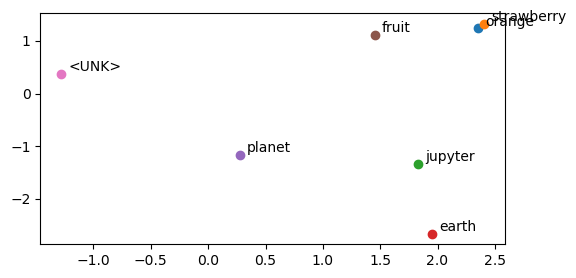

In [29]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(unique_words):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [30]:
earth = get_embed('earth')
earth

(1.953340768814087, -2.6598598957061768)

In [31]:
unk = get_embed('<UNK>')
unk

(-1.2798641920089722, 0.3757193684577942)

In [32]:
np.array(earth) @ np.array(unk)

-3.499371784997365

In [33]:
planet = get_embed('planet')

In [34]:
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(earth), np.array(unk)))
print(cosine_similarity(np.array(earth), np.array(planet)))

-0.7949755383332616
0.9206110985478353
